In [1]:
import torch
import torch.nn as nn
from captcha_dataset import CaptchaData
from model import (Model, VGG)

In [3]:
# 1 create vgg-like net
image_size = (3, 60, 120)
num_classes = 26*4
conv_pattern = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
hidden_pattern = (2, 512)
    
net = VGG(image_size, num_classes, conv_pattern, hidden_pattern, dropout=0.5)
num_params = sum(p.numel() for p in net.parameters())

print(net)  # net architecture
print(f"Total parameters: {num_params}") # total parameters

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
# 2 load data
from torch.utils.data import DataLoader

train_dataset = CaptchaData('../samples/qq', train=True)
test_dataset = CaptchaData('../samples/qq', train=False)

# batch train/test data
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [5]:
# 3 train and evaluate model
def evaluate(output, target):
    # one char per row
    output, target = output.view(-1, 26), target.view(-1, 26)
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    target = torch.argmax(target, dim=1)

    # 4 char per row
    output, target = output.view(-1, 4), target.view(-1, 4)
    evaluation = [1 if torch.equal(i, j) else 0 for i, j in zip(target, output)]
    return sum(evaluation) / len(evaluation)

In [6]:
# train and validation process
from model import Model

fun_loss = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

filename = 'model.pt'
model = Model(model=net, optimizer=optimizer, loss=fun_loss, stored_model_filename=filename)
model.fit(
    epochs=20, 
    train_data=train_loader, 
    validate_data=test_loader, 
    fun_evaluate=evaluate,
    output_step=100,
    store_model_filename=filename)

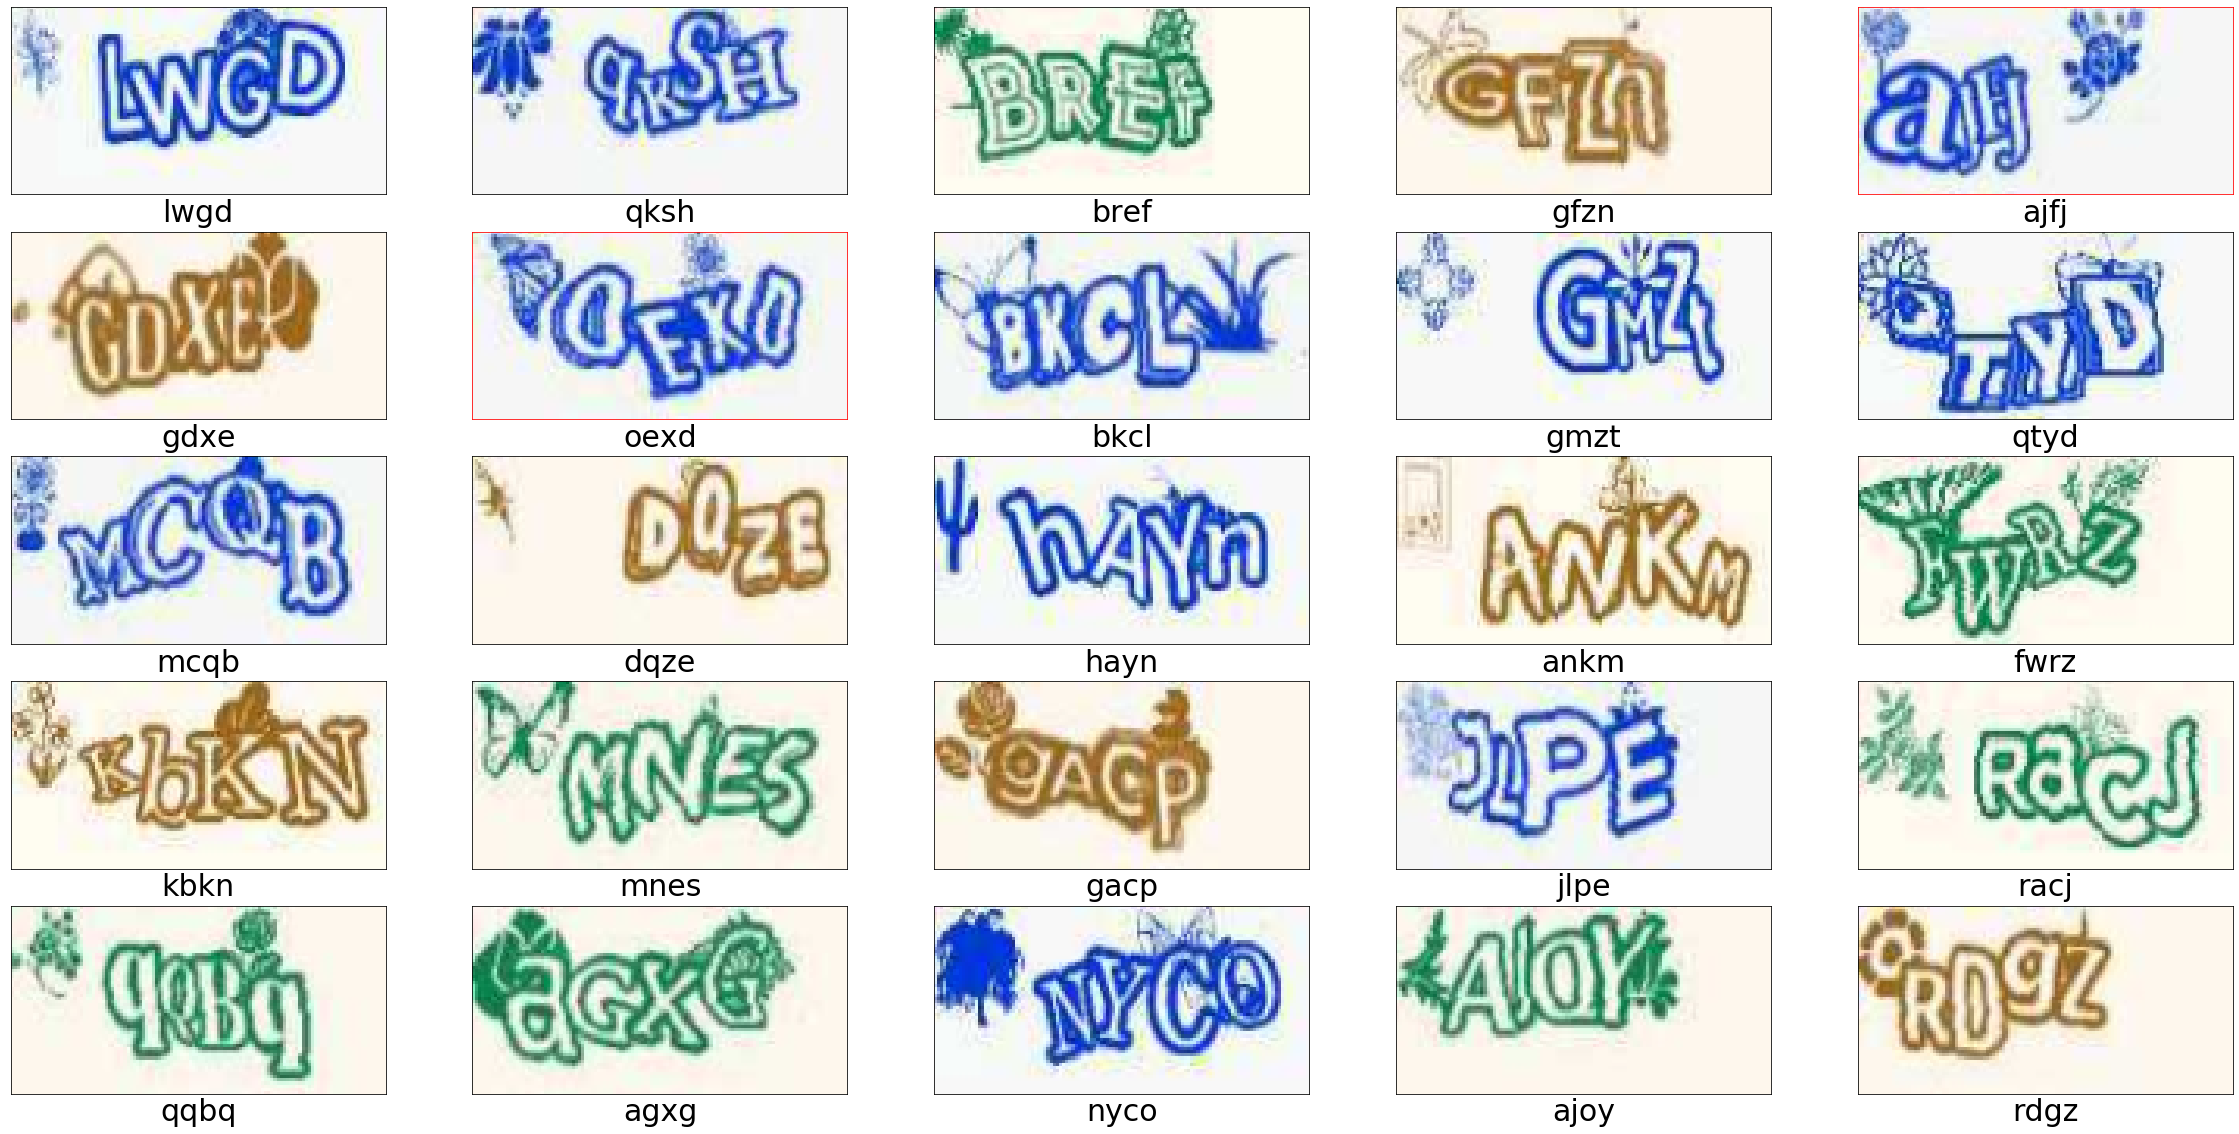

In [14]:
# 4 prediction example
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

def decode(tensor):
    '''Decode tensor to label.'''
    codes = tensor.cpu().detach().numpy()
    label = ''
    for i in range(4):
        item = codes[i*26:(i+1)*26]
        idx = np.argmax(item)
        label += chr(ord('a')+idx)
    return label

num, num_all = 5, len(train_dataset)
plt.figure(figsize=(40, 20))

for i in range(num**2):
    image, label = train_dataset[random.randint(0, num_all)]

    # predict labels
    output = model.predict(image.unsqueeze(0))
    predict_label = decode(output[0])
    
    # real labels
    label = decode(label)

    # plot
    plt.subplot(num, num,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy().transpose(1,2,0))
    plt.xlabel(predict_label, size=30)
    
    # mark error prediction with red border
    if predict_label != label:
        ax = plt.gca()
        for name, border in ax.spines.items():
            border.set_color('red')
plt.show()